[View in Colaboratory](https://colab.research.google.com/github/codewarriors2018/ValidacijaPotpisa/blob/master/ProjekatNMKeras.ipynb)

In [0]:
import numpy as np
import keras
from keras import backend as K
from keras.models import Sequential
from keras.layers import Activation
from keras.layers.core import Dense, Flatten
from keras.optimizers import Adam
from keras.metrics import categorical_crossentropy
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import *
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt
%matplotlib inline
from google.colab import auth
from googleapiclient.discovery import build
import io , requests, os
import sys
auth.authenticate_user()
from googleapiclient.discovery import build
drive_service = build('drive', 'v3')

In [0]:
def get_parent_folder(folder_name):
  page_token = None
  folder_array = []
  query = "name='%s' and mimeType='application/vnd.google-apps.folder'" % folder_name
  while True:
      response = drive_service.files().list(q=query,
                                          spaces='drive',
                                          fields='nextPageToken, files(id, name)',
                                          pageToken=page_token).execute()
      for file in response.get('files', []):
          folder_array.append({"name" : file.get('name'), "id" : file.get('id')})
      page_token = response.get('nextPageToken', None)
      if page_token is None:
          break
  return folder_array

In [0]:
def get_files_from_parent(parent_id):
  page_token = None
  folder_array = dict()
  query = "'%s' in parents" % parent_id
  while True:
      response = drive_service.files().list(q=query,
                                          spaces='drive',
                                          fields='nextPageToken, files(id, name)',
                                          pageToken=page_token).execute()
      for file in response.get('files', []):
          folder_array.update({file.get('name'):file.get('id')})
      page_token = response.get('nextPageToken', None)
      if page_token is None:
          break
  return folder_array

In [0]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
  
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [0]:
def get_file_buffer(file_id, verbose=0):
  from googleapiclient.http import MediaIoBaseDownload
  request = drive_service.files().get_media(fileId=file_id)
  downloaded = io.BytesIO()
  downloader = MediaIoBaseDownload(downloaded, request)
  done = False
  while done is False:
    progress, done = downloader.next_chunk()
    if verbose:
      sys.stdout.flush()
      sys.stdout.write('\r')
      percentage_done = progress.resumable_progress * 100/progress.total_size
      sys.stdout.write("[%-100s] %d%%" % ('='*int(percentage_done), int(percentage_done)))
  downloaded.seek(0)
  return downloaded

In [0]:

def loadFiles(srcFolderPath, parentFolderName):
  print(parent_folder)
  parent_folder[0]["id"]
  input_file_meta = get_files_from_parent(parent_folder[0]["id"])
  print(input_file_meta)
  for file, id in input_file_meta.items():
    downloaded = get_file_buffer(id, verbose=1)
    dest_file = os.path.join(SOURCE_FOLDER, file)
    print("processing %s data" % file)
    with open(dest_file, "wb") as out:
      out.write(downloaded.read())
      print("Done %s" % dest_file)

In [0]:
def plots(ims, figsize=(12,6), rows=1, interp=False, titles=None):
    if type(ims[0]) is np.ndarray:
        ims = np.array(ims).astype(np.uint8)
        if (ims.shape[-1] != 3):
            ims = ims.transpose((0,2,3,1))
    f = plt.figure(figsize=figsize)
    cols = len(ims)//rows if len(ims) % 2 == 0 else len(ims)//rows + 1
    for i in range(len(ims)):
        sp = f.add_subplot(rows, cols, i+1)
        sp.axis('Off')
        if titles is not None:
            sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i], interpolation=None if interp else 'none')

In [9]:
os.mkdir('training')
os.mkdir('validation')
os.mkdir('test')

os.chdir('training')
os.mkdir('genuine')
os.mkdir('forgeries')
os.chdir('..')

os.chdir('validation')
os.mkdir('genuine')
os.mkdir('forgeries')
os.chdir('..')

os.chdir('test')
os.mkdir('genuine')
os.mkdir('forgeries')
os.chdir('..')
!ls

datalab  test  training  validation


In [10]:
parent_folder = get_parent_folder('genuine')
SOURCE_FOLDER='/content/training/genuine/'
loadFiles(SOURCE_FOLDER, parent_folder)

parent_folder = get_parent_folder('genuineVal')
SOURCE_FOLDER='/content/validation/genuine/'
loadFiles(SOURCE_FOLDER, parent_folder)

parent_folder = get_parent_folder('genuineTest')
SOURCE_FOLDER='/content/test/genuine/'
loadFiles(SOURCE_FOLDER, parent_folder)

parent_folder = get_parent_folder('forgeries')
SOURCE_FOLDER='/content/training/forgeries/'
loadFiles(SOURCE_FOLDER, parent_folder)

parent_folder = get_parent_folder('forgeriesVal')
SOURCE_FOLDER='/content/validation/forgeries/'
loadFiles(SOURCE_FOLDER, parent_folder)

parent_folder = get_parent_folder('forgeriesTest')
SOURCE_FOLDER='/content/test/forgeries/'
loadFiles(SOURCE_FOLDER, parent_folder)

[{'name': u'genuine', 'id': u'1HJ998I3ybofTsFKKFFoiG3xhl3wa6JrW'}]
{u'014_10.PNG': u'1U4eSZgjdXcyQcDM8Gru12tO52IpXkqOC', u'002_12.PNG': u'19lf3SzZIzBGvn08dp6FRJQ2hlvB37N3m', u'012_15.PNG': u'1OzqqWvcKELqSHrUUjeLyCcdDU8e1Zh2t', u'016_12.PNG': u'10vCKRg6ynaLQ6JK80Mi_egcJ_hVpuEfk', u'015_23.PNG': u'1v0SlUdcJfvdRbYsa-ymH4-ufMV65DetB', u'003_09.PNG': u'1k_t9cUe66WiQNPySo0WFLYa7_uTKR2x_', u'004_10.PNG': u'1OyhfDrvIOIdwKvOXdYAbuvFN_nPlqioo', u'003_24.PNG': u'1zasyZFCYjrsuZqHGlZ2gKNuHLUA9sVHJ', u'003_01.PNG': u'1EB6z0M0IW9gW6celkZy_CWLHE9fDU1wy', u'012_21.PNG': u'1VMBJol1ryEs2hyZwhdkxLWZa3zdz5Zx6', u'012_01.PNG': u'1dZKO32ugRAp5OGSua5B3kIIsDrI-ah2S', u'015_22.PNG': u'1fzneh3Rjves7Mo6Ih7sfTYLb8aDYwDtw', u'001_03.PNG': u'10SYhd2pZeSxwJRCSyu9G2EFDw3R6Fsfj', u'002_07.PNG': u'180eOQ6qG-vEp9Apk8OH1D0Gx8qjzYvbg', u'014_03.PNG': u'1ykl6om4E_QS56WMww8rTcI_R1QKgAk0h', u'002_23.PNG': u'1lCygY2d4gTCm5scoO1hYIc3cWUagUNso', u'012_09.PNG': u'1lvOPN7iPC0V50fGnnv1Tsj9Zx6kG3c9k', u'012_18.PNG': u'1K9O8Ksc8julS8

[====================================================================================================] 100%processing 004_10.PNG data
Done /content/training/genuine/004_10.PNG
[====================================================================================================] 100%processing 003_24.PNG data
Done /content/training/genuine/003_24.PNG
[====================================================================================================] 100%processing 003_01.PNG data
Done /content/training/genuine/003_01.PNG
[====================================================================================================] 100%processing 012_21.PNG data
Done /content/training/genuine/012_21.PNG
[====================================================================================================] 100%processing 012_01.PNG data
Done /content/training/genuine/012_01.PNG
[====================================================================================================] 100%processing 01

[====================================================================================================] 100%processing 012_23.PNG data
Done /content/training/genuine/012_23.PNG
[====================================================================================================] 100%processing 001_21.PNG data
Done /content/training/genuine/001_21.PNG
[====================================================================================================] 100%processing 001_17.PNG data
Done /content/training/genuine/001_17.PNG
[====================================================================================================] 100%processing 001_01.PNG data
Done /content/training/genuine/001_01.PNG
[====================================================================================================] 100%processing 002_11.PNG data
Done /content/training/genuine/002_11.PNG
[====================================================================================================] 100%processing 00

[====================================================================================================] 100%processing 009_02.PNG data
Done /content/training/genuine/009_02.PNG
[====================================================================================================] 100%processing 003_20.PNG data
Done /content/training/genuine/003_20.PNG
[====================================================================================================] 100%processing 009_15.PNG data
Done /content/training/genuine/009_15.PNG
[====================================================================================================] 100%processing 015_06.PNG data
Done /content/training/genuine/015_06.PNG
[====================================================================================================] 100%processing 015_09.PNG data
Done /content/training/genuine/015_09.PNG
[====================================================================================================] 100%processing 01

[====================================================================================================] 100%processing 012_03.PNG data
Done /content/training/genuine/012_03.PNG
[====================================================================================================] 100%processing 012_11.PNG data
Done /content/training/genuine/012_11.PNG
[====================================================================================================] 100%processing 014_14.PNG data
Done /content/training/genuine/014_14.PNG
[====================================================================================================] 100%processing 006_19.PNG data
Done /content/training/genuine/006_19.PNG
[====================================================================================================] 100%processing 006_18.PNG data
Done /content/training/genuine/006_18.PNG
[====================================================================================================] 100%processing 00

[====================================================================================================] 100%processing 001_20.PNG data
Done /content/training/genuine/001_20.PNG
[====================================================================================================] 100%processing 014_06.PNG data
Done /content/training/genuine/014_06.PNG
[====================================================================================================] 100%processing 012_02.PNG data
Done /content/training/genuine/012_02.PNG
[====================================================================================================] 100%processing 012_17.PNG data
Done /content/training/genuine/012_17.PNG
[====================================================================================================] 100%processing 001_08.PNG data
Done /content/training/genuine/001_08.PNG
[====================================================================================================] 100%processing 01

[====================================================================================================] 100%processing 006_10.PNG data
Done /content/training/genuine/006_10.PNG
[====================================================================================================] 100%processing 009_24.PNG data
Done /content/training/genuine/009_24.PNG
[====================================================================================================] 100%processing 015_05.PNG data
Done /content/training/genuine/015_05.PNG
[====================================================================================================] 100%processing 001_04.PNG data
Done /content/training/genuine/001_04.PNG
[====================================================================================================] 100%processing 009_13.PNG data
Done /content/training/genuine/009_13.PNG
[====================================================================================================] 100%processing 00

[====================================================================================================] 100%processing 002_09.PNG data
Done /content/training/genuine/002_09.PNG
[====================================================================================================] 100%processing 003_13.PNG data
Done /content/training/genuine/003_13.PNG
[====================================================================================================] 100%processing 002_03.PNG data
Done /content/training/genuine/002_03.PNG
[====================================================================================================] 100%processing 006_02.PNG data
Done /content/training/genuine/006_02.PNG
[====================================================================================================] 100%processing 003_22.PNG data
Done /content/training/genuine/003_22.PNG
[====================================================================================================] 100%processing 01

[====================================================================================================] 100%processing 001_12.PNG data
Done /content/training/genuine/001_12.PNG
[====================================================================================================] 100%processing 006_04.PNG data
Done /content/training/genuine/006_04.PNG
[{'name': u'genuineVal', 'id': u'1JfwPqd35M-Q5CQNQbgtIvh2J4x1ONu2H'}]
{u'02_043.png': u'1UeMtY5guvqEhsf-bvQZz9n_3S_UmkuZu', u'01_034.png': u'1-RWLhi0cTerABqFVdp6gP5gV47UuzgE8', u'02_022.png': u'1qaMLubDHBDwNJkfia-a-ygXkI1IBaVMV', u'01_045.png': u'1hVahcnqYXoLY4KSx6_01y40XT_jmw9xA', u'02_023.png': u'1_w1HQjOmZI3SshUv8ZPjjXDj7hcfmbFb', u'01_046.png': u'1fgYHXmpQFhJ7qDqnKh3N2OdCVsDOfTF4', u'01_019.png': u'1J3I5BfHxO1Hb8ElFWvThIvECfPd0-LMg', u'01_047.png': u'1AThWJFlepGfELVBQjWvFN2zG5DhlbUrY', u'01_043.png': u'1kLhc1M4SQgD9Pvkh4rUszVI5DW487DQy', u'01_029.png': u'19bkxPPbTw3X5evrIQHgVkbCBR9IzwCDp', u'01_042.png': u'1nxIxm9P3aHnQ45M77gM6B8NTAIF_H

[====================================================================================================] 100%processing 02_018.png data
Done /content/validation/genuine/02_018.png
[====================================================================================================] 100%processing 02_035.png data
Done /content/validation/genuine/02_035.png
[====================================================================================================] 100%processing 02_033.png data
Done /content/validation/genuine/02_033.png
[====================================================================================================] 100%processing 02_017.png data
Done /content/validation/genuine/02_017.png
[====================================================================================================] 100%processing 01_017.png data
Done /content/validation/genuine/01_017.png
[====================================================================================================] 100%pro

[====================================================================================================] 100%processing 01_020.png data
Done /content/validation/genuine/01_020.png
[====================================================================================================] 100%processing 01_061.png data
Done /content/validation/genuine/01_061.png
[====================================================================================================] 100%processing 02_024.png data
Done /content/validation/genuine/02_024.png
[====================================================================================================] 100%processing 01_064.png data
Done /content/validation/genuine/01_064.png
[====================================================================================================] 100%processing 01_018.png data
Done /content/validation/genuine/01_018.png
[====================================================================================================] 100%pro

[====================================================================================================] 100%processing 01_031.png data
Done /content/validation/genuine/01_031.png
[====================================================================================================] 100%processing 01_068.png data
Done /content/validation/genuine/01_068.png
[====================================================================================================] 100%processing 02_028.png data
Done /content/validation/genuine/02_028.png
[====================================================================================================] 100%processing 02_021.png data
Done /content/validation/genuine/02_021.png
[{'name': u'genuineTest', 'id': u'1A_2HY4yhWgOTDCWRBRxCT9IX7E69Sze_'}]
{u'03_018.png': u'18OtIHVgfZTANgsY9cBtLVDisq31ipVZj', u'02_046.png': u'1vRnA6KYxWmDagf1DES9Y501InVZM6qvC', u'02_057.png': u'1f39Wq9MmiP7TUWXeuqhCNx3BFi3Lt5sO', u'01_032.png': u'1btznrfausDROCeh8mj3RrILIU25GA4Lt', u'05

[====================================================================================================] 100%processing 02_046.png data
Done /content/test/genuine/02_046.png
[====================================================================================================] 100%processing 02_057.png data
Done /content/test/genuine/02_057.png
[====================================================================================================] 100%processing 01_032.png data
Done /content/test/genuine/01_032.png
[====================================================================================================] 100%processing 05_040.png data
Done /content/test/genuine/05_040.png
[====================================================================================================] 100%processing 06_041.png data
Done /content/test/genuine/06_041.png
[====================================================================================================] 100%processing 11_067.png data
Done /

[====================================================================================================] 100%processing 12_031.png data
Done /content/test/genuine/12_031.png
[====================================================================================================] 100%processing 12_034.png data
Done /content/test/genuine/12_034.png
[====================================================================================================] 100%processing 07_055.png data
Done /content/test/genuine/07_055.png
[====================================================================================================] 100%processing 06_062.png data
Done /content/test/genuine/06_062.png
[====================================================================================================] 100%processing 02_019.png data
Done /content/test/genuine/02_019.png
[====================================================================================================] 100%processing 08_061.png data
Done /

[====================================================================================================] 100%processing 12_052.png data
Done /content/test/genuine/12_052.png
[====================================================================================================] 100%processing 04_051.png data
Done /content/test/genuine/04_051.png
[====================================================================================================] 100%processing 11_056.png data
Done /content/test/genuine/11_056.png
[====================================================================================================] 100%processing 10_060.png data
Done /content/test/genuine/10_060.png
[====================================================================================================] 100%processing 11_035.png data
Done /content/test/genuine/11_035.png
[====================================================================================================] 100%processing 02_062.png data
Done /

[====================================================================================================] 100%processing 01_020.png data
Done /content/test/genuine/01_020.png
[====================================================================================================] 100%processing 05_013.png data
Done /content/test/genuine/05_013.png
[====================================================================================================] 100%processing 10_032.png data
Done /content/test/genuine/10_032.png
[====================================================================================================] 100%processing 03_031.png data
Done /content/test/genuine/03_031.png
[====================================================================================================] 100%processing 08_062.png data
Done /content/test/genuine/08_062.png
[====================================================================================================] 100%processing 11_023.png data
Done /

[====================================================================================================] 100%processing 01_030.png data
Done /content/test/genuine/01_030.png
[====================================================================================================] 100%processing 06_055.png data
Done /content/test/genuine/06_055.png
[====================================================================================================] 100%processing 06_045.png data
Done /content/test/genuine/06_045.png
[====================================================================================================] 100%processing 02_049.png data
Done /content/test/genuine/02_049.png
[====================================================================================================] 100%processing 05_057.png data
Done /content/test/genuine/05_057.png
[====================================================================================================] 100%processing 03_020.png data
Done /

[====================================================================================================] 100%processing 10_035.png data
Done /content/test/genuine/10_035.png
[====================================================================================================] 100%processing 09_045.png data
Done /content/test/genuine/09_045.png
[====================================================================================================] 100%processing 03_048.png data
Done /content/test/genuine/03_048.png
[====================================================================================================] 100%processing 09_053.png data
Done /content/test/genuine/09_053.png
[====================================================================================================] 100%processing 05_052.png data
Done /content/test/genuine/05_052.png
[====================================================================================================] 100%processing 04_061.png data
Done /

[====================================================================================================] 100%processing 06_053.png data
Done /content/test/genuine/06_053.png
[====================================================================================================] 100%processing 09_037.png data
Done /content/test/genuine/09_037.png
[====================================================================================================] 100%processing 01_056.png data
Done /content/test/genuine/01_056.png
[====================================================================================================] 100%processing 09_069.png data
Done /content/test/genuine/09_069.png
[====================================================================================================] 100%processing 09_068.png data
Done /content/test/genuine/09_068.png
[====================================================================================================] 100%processing 07_032.png data
Done /

[====================================================================================================] 100%processing 09_052.png data
Done /content/test/genuine/09_052.png
[====================================================================================================] 100%processing 04_059.png data
Done /content/test/genuine/04_059.png
[====================================================================================================] 100%processing 11_034.png data
Done /content/test/genuine/11_034.png
[====================================================================================================] 100%processing 01_031.png data
Done /content/test/genuine/01_031.png
[====================================================================================================] 100%processing 04_024.png data
Done /content/test/genuine/04_024.png
[====================================================================================================] 100%processing 04_018.png data
Done /

[====================================================================================================] 100%processing 10_043.png data
Done /content/test/genuine/10_043.png
[====================================================================================================] 100%processing 04_053.png data
Done /content/test/genuine/04_053.png
[====================================================================================================] 100%processing 10_067.png data
Done /content/test/genuine/10_067.png
[====================================================================================================] 100%processing 05_060.png data
Done /content/test/genuine/05_060.png
[====================================================================================================] 100%processing 02_035.png data
Done /content/test/genuine/02_035.png
[====================================================================================================] 100%processing 02_034.png data
Done /

[====================================================================================================] 100%processing 04_068.png data
Done /content/test/genuine/04_068.png
[====================================================================================================] 100%processing 08_053.png data
Done /content/test/genuine/08_053.png
[====================================================================================================] 100%processing 06_025.png data
Done /content/test/genuine/06_025.png
[====================================================================================================] 100%processing 07_036.png data
Done /content/test/genuine/07_036.png
[====================================================================================================] 100%processing 08_067.png data
Done /content/test/genuine/08_067.png
[====================================================================================================] 100%processing 04_069.png data
Done /

[====================================================================================================] 100%processing 06_017.png data
Done /content/test/genuine/06_017.png
[====================================================================================================] 100%processing 12_057.png data
Done /content/test/genuine/12_057.png
[====================================================================================================] 100%processing 12_038.png data
Done /content/test/genuine/12_038.png
[====================================================================================================] 100%processing 12_039.png data
Done /content/test/genuine/12_039.png
[====================================================================================================] 100%processing 03_023.png data
Done /content/test/genuine/03_023.png
[====================================================================================================] 100%processing 04_029.png data
Done /

[====================================================================================================] 100%processing 10_063.png data
Done /content/test/genuine/10_063.png
[====================================================================================================] 100%processing 10_062.png data
Done /content/test/genuine/10_062.png
[====================================================================================================] 100%processing 02_053.png data
Done /content/test/genuine/02_053.png
[====================================================================================================] 100%processing 07_068.png data
Done /content/test/genuine/07_068.png
[====================================================================================================] 100%processing 04_031.png data
Done /content/test/genuine/04_031.png
[====================================================================================================] 100%processing 07_040.png data
Done /

[====================================================================================================] 100%processing 08_063.png data
Done /content/test/genuine/08_063.png
[====================================================================================================] 100%processing 06_050.png data
Done /content/test/genuine/06_050.png
[====================================================================================================] 100%processing 11_058.png data
Done /content/test/genuine/11_058.png
[====================================================================================================] 100%processing 04_062.png data
Done /content/test/genuine/04_062.png
[====================================================================================================] 100%processing 11_032.png data
Done /content/test/genuine/11_032.png
[====================================================================================================] 100%processing 02_031.png data
Done /

[====================================================================================================] 100%processing 05_025.png data
Done /content/test/genuine/05_025.png
[====================================================================================================] 100%processing 05_019.png data
Done /content/test/genuine/05_019.png
[====================================================================================================] 100%processing 07_060.png data
Done /content/test/genuine/07_060.png
[====================================================================================================] 100%processing 12_051.png data
Done /content/test/genuine/12_051.png
[====================================================================================================] 100%processing 06_051.png data
Done /content/test/genuine/06_051.png
[====================================================================================================] 100%processing 01_022.png data
Done /

[====================================================================================================] 100%processing 10_037.png data
Done /content/test/genuine/10_037.png
[====================================================================================================] 100%processing 09_058.png data
Done /content/test/genuine/09_058.png
[====================================================================================================] 100%processing 06_047.png data
Done /content/test/genuine/06_047.png
[====================================================================================================] 100%processing 09_054.png data
Done /content/test/genuine/09_054.png
[====================================================================================================] 100%processing 10_042.png data
Done /content/test/genuine/10_042.png
[====================================================================================================] 100%processing 03_067.png data
Done /

[====================================================================================================] 100%processing 07_018.png data
Done /content/test/genuine/07_018.png
[====================================================================================================] 100%processing 07_056.png data
Done /content/test/genuine/07_056.png
[====================================================================================================] 100%processing 04_021.png data
Done /content/test/genuine/04_021.png
[====================================================================================================] 100%processing 09_030.png data
Done /content/test/genuine/09_030.png
[====================================================================================================] 100%processing 09_031.png data
Done /content/test/genuine/09_031.png
[====================================================================================================] 100%processing 07_017.png data
Done /

[====================================================================================================] 100%processing 08_036.png data
Done /content/test/genuine/08_036.png
[====================================================================================================] 100%processing 04_040.png data
Done /content/test/genuine/04_040.png
[====================================================================================================] 100%processing 02_039.png data
Done /content/test/genuine/02_039.png
[====================================================================================================] 100%processing 12_019.png data
Done /content/test/genuine/12_019.png
[====================================================================================================] 100%processing 10_069.png data
Done /content/test/genuine/10_069.png
[====================================================================================================] 100%processing 11_018.png data
Done /

[====================================================================================================] 100%processing 05_021.png data
Done /content/test/genuine/05_021.png
[====================================================================================================] 100%processing 03_035.png data
Done /content/test/genuine/03_035.png
[====================================================================================================] 100%processing 10_050.png data
Done /content/test/genuine/10_050.png
[====================================================================================================] 100%processing 09_048.png data
Done /content/test/genuine/09_048.png
[====================================================================================================] 100%processing 06_039.png data
Done /content/test/genuine/06_039.png
[====================================================================================================] 100%processing 02_033.png data
Done /

[====================================================================================================] 100%processing 09_064.png data
Done /content/test/genuine/09_064.png
[====================================================================================================] 100%processing 10_018.png data
Done /content/test/genuine/10_018.png
[====================================================================================================] 100%processing 06_065.png data
Done /content/test/genuine/06_065.png
[====================================================================================================] 100%processing 04_025.png data
Done /content/test/genuine/04_025.png
[====================================================================================================] 100%processing 08_013.png data
Done /content/test/genuine/08_013.png
[====================================================================================================] 100%processing 12_050.png data
Done /

[====================================================================================================] 100%processing 09_025.png data
Done /content/test/genuine/09_025.png
[====================================================================================================] 100%processing 07_062.png data
Done /content/test/genuine/07_062.png
[====================================================================================================] 100%processing 02_047.png data
Done /content/test/genuine/02_047.png
[====================================================================================================] 100%processing 09_013.png data
Done /content/test/genuine/09_013.png
[====================================================================================================] 100%processing 02_066.png data
Done /content/test/genuine/02_066.png
[====================================================================================================] 100%processing 07_066.png data
Done /

[====================================================================================================] 100%processing 0105004_01.png data
Done /content/training/forgeries/0105004_01.png
[====================================================================================================] 100%processing 0106015_03.png data
Done /content/training/forgeries/0106015_03.png
[====================================================================================================] 100%processing 0103004_02.png data
Done /content/training/forgeries/0103004_02.png
[====================================================================================================] 100%processing 0210015_01.png data
Done /content/training/forgeries/0210015_01.png
[====================================================================================================] 100%processing 0210012_04.png data
Done /content/training/forgeries/0210012_04.png
[=====================================================================

[====================================================================================================] 100%processing 0210015_04.png data
Done /content/training/forgeries/0210015_04.png
[====================================================================================================] 100%processing 0107016_02.png data
Done /content/training/forgeries/0107016_02.png
[====================================================================================================] 100%processing 0104014_03.png data
Done /content/training/forgeries/0104014_03.png
[====================================================================================================] 100%processing 0104014_04.png data
Done /content/training/forgeries/0104014_04.png
[====================================================================================================] 100%processing 0202016_03.png data
Done /content/training/forgeries/0202016_03.png
[=====================================================================

[====================================================================================================] 100%processing 0210015_03.png data
Done /content/training/forgeries/0210015_03.png
[====================================================================================================] 100%processing 0118002_01.png data
Done /content/training/forgeries/0118002_01.png
[====================================================================================================] 100%processing 0202006_04.png data
Done /content/training/forgeries/0202006_04.png
[====================================================================================================] 100%processing 0121003_03.png data
Done /content/training/forgeries/0121003_03.png
[====================================================================================================] 100%processing 0121003_02.png data
Done /content/training/forgeries/0121003_02.png
[=====================================================================

[====================================================================================================] 100%processing 0205006_02.png data
Done /content/training/forgeries/0205006_02.png
[====================================================================================================] 100%processing 0127016_04.png data
Done /content/training/forgeries/0127016_04.png
[====================================================================================================] 100%processing 0202016_01.png data
Done /content/training/forgeries/0202016_01.png
[====================================================================================================] 100%processing 0102014_02.png data
Done /content/training/forgeries/0102014_02.png
[====================================================================================================] 100%processing 0102014_03.png data
Done /content/training/forgeries/0102014_03.png
[=====================================================================

[====================================================================================================] 100%processing 01_0105041.PNG data
Done /content/validation/forgeries/01_0105041.PNG
[====================================================================================================] 100%processing 01_0120032.PNG data
Done /content/validation/forgeries/01_0120032.PNG
[====================================================================================================] 100%processing 01_0118065.PNG data
Done /content/validation/forgeries/01_0118065.PNG
[====================================================================================================] 100%processing 01_0108069.PNG data
Done /content/validation/forgeries/01_0108069.PNG
[====================================================================================================] 100%processing 01_0102024.PNG data
Done /content/validation/forgeries/01_0102024.PNG
[===========================================================

[====================================================================================================] 100%processing 01_0107053.PNG data
Done /content/validation/forgeries/01_0107053.PNG
[====================================================================================================] 100%processing 01_0116045.PNG data
Done /content/validation/forgeries/01_0116045.PNG
[====================================================================================================] 100%processing 01_0119024.PNG data
Done /content/validation/forgeries/01_0119024.PNG
[====================================================================================================] 100%processing 01_0109036.PNG data
Done /content/validation/forgeries/01_0109036.PNG
[====================================================================================================] 100%processing 01_0120034.PNG data
Done /content/validation/forgeries/01_0120034.PNG
[===========================================================

[====================================================================================================] 100%processing 01_0103031.PNG data
Done /content/validation/forgeries/01_0103031.PNG
[====================================================================================================] 100%processing 01_0115035.PNG data
Done /content/validation/forgeries/01_0115035.PNG
[====================================================================================================] 100%processing 01_0119026.PNG data
Done /content/validation/forgeries/01_0119026.PNG
[====================================================================================================] 100%processing 01_0120055.PNG data
Done /content/validation/forgeries/01_0120055.PNG
[====================================================================================================] 100%processing 01_0107046.PNG data
Done /content/validation/forgeries/01_0107046.PNG
[===========================================================

[====================================================================================================] 100%processing 02_0103044.PNG data
Done /content/test/forgeries/02_0103044.PNG
[====================================================================================================] 100%processing 03_0126050.PNG data
Done /content/test/forgeries/03_0126050.PNG
[====================================================================================================] 100%processing 03_0206061.PNG data
Done /content/test/forgeries/03_0206061.PNG
[====================================================================================================] 100%processing 03_0208057.PNG data
Done /content/test/forgeries/03_0208057.PNG
[====================================================================================================] 100%processing 02_0205067.PNG data
Done /content/test/forgeries/02_0205067.PNG
[=========================================================================================

[====================================================================================================] 100%processing 01_0106048.PNG data
Done /content/test/forgeries/01_0106048.PNG
[====================================================================================================] 100%processing 02_0206061.PNG data
Done /content/test/forgeries/02_0206061.PNG
[====================================================================================================] 100%processing 04_0108039.PNG data
Done /content/test/forgeries/04_0108039.PNG
[====================================================================================================] 100%processing 01_0104059.PNG data
Done /content/test/forgeries/01_0104059.PNG
[====================================================================================================] 100%processing 02_0102039.PNG data
Done /content/test/forgeries/02_0102039.PNG
[=========================================================================================

[====================================================================================================] 100%processing 01_0214037.PNG data
Done /content/test/forgeries/01_0214037.PNG
[====================================================================================================] 100%processing 01_0118065.PNG data
Done /content/test/forgeries/01_0118065.PNG
[====================================================================================================] 100%processing 03_0208054.PNG data
Done /content/test/forgeries/03_0208054.PNG
[====================================================================================================] 100%processing 02_0213030.PNG data
Done /content/test/forgeries/02_0213030.PNG
[====================================================================================================] 100%processing 01_0120055.PNG data
Done /content/test/forgeries/01_0120055.PNG
[=========================================================================================

[====================================================================================================] 100%processing 01_0213038.PNG data
Done /content/test/forgeries/01_0213038.PNG
[====================================================================================================] 100%processing 03_0108046.PNG data
Done /content/test/forgeries/03_0108046.PNG
[====================================================================================================] 100%processing 04_0119024.PNG data
Done /content/test/forgeries/04_0119024.PNG
[====================================================================================================] 100%processing 01_0208037.PNG data
Done /content/test/forgeries/01_0208037.PNG
[====================================================================================================] 100%processing 02_0120055.PNG data
Done /content/test/forgeries/02_0120055.PNG
[=========================================================================================

[====================================================================================================] 100%processing 04_0202053.PNG data
Done /content/test/forgeries/04_0202053.PNG
[====================================================================================================] 100%processing 02_0211044.PNG data
Done /content/test/forgeries/02_0211044.PNG
[====================================================================================================] 100%processing 02_0214037.PNG data
Done /content/test/forgeries/02_0214037.PNG
[====================================================================================================] 100%processing 01_0107042.PNG data
Done /content/test/forgeries/01_0107042.PNG
[====================================================================================================] 100%processing 02_0107017.PNG data
Done /content/test/forgeries/02_0107017.PNG
[=========================================================================================

[====================================================================================================] 100%processing 04_0115029.PNG data
Done /content/test/forgeries/04_0115029.PNG
[====================================================================================================] 100%processing 03_0111045.PNG data
Done /content/test/forgeries/03_0111045.PNG
[====================================================================================================] 100%processing 03_0123037.PNG data
Done /content/test/forgeries/03_0123037.PNG
[====================================================================================================] 100%processing 04_0120051.PNG data
Done /content/test/forgeries/04_0120051.PNG
[====================================================================================================] 100%processing 02_0106048.PNG data
Done /content/test/forgeries/02_0106048.PNG
[=========================================================================================

[====================================================================================================] 100%processing 01_0212028.PNG data
Done /content/test/forgeries/01_0212028.PNG
[====================================================================================================] 100%processing 04_0112061.PNG data
Done /content/test/forgeries/04_0112061.PNG
[====================================================================================================] 100%processing 02_0121031.PNG data
Done /content/test/forgeries/02_0121031.PNG
[====================================================================================================] 100%processing 03_0211066.PNG data
Done /content/test/forgeries/03_0211066.PNG
[====================================================================================================] 100%processing 03_0115019.PNG data
Done /content/test/forgeries/03_0115019.PNG
[=========================================================================================

[====================================================================================================] 100%processing 03_0214054.PNG data
Done /content/test/forgeries/03_0214054.PNG
[====================================================================================================] 100%processing 02_0109036.PNG data
Done /content/test/forgeries/02_0109036.PNG
[====================================================================================================] 100%processing 04_0101027.PNG data
Done /content/test/forgeries/04_0101027.PNG
[====================================================================================================] 100%processing 03_0118055.PNG data
Done /content/test/forgeries/03_0118055.PNG
[====================================================================================================] 100%processing 04_0206049.PNG data
Done /content/test/forgeries/04_0206049.PNG
[=========================================================================================

[====================================================================================================] 100%processing 02_0115035.PNG data
Done /content/test/forgeries/02_0115035.PNG
[====================================================================================================] 100%processing 04_0120055.PNG data
Done /content/test/forgeries/04_0120055.PNG
[====================================================================================================] 100%processing 02_0204048.PNG data
Done /content/test/forgeries/02_0204048.PNG
[====================================================================================================] 100%processing 03_0117020.PNG data
Done /content/test/forgeries/03_0117020.PNG
[====================================================================================================] 100%processing 03_0211044.PNG data
Done /content/test/forgeries/03_0211044.PNG
[=========================================================================================

[====================================================================================================] 100%processing 01_0105064.PNG data
Done /content/test/forgeries/01_0105064.PNG
[====================================================================================================] 100%processing 02_0207052.PNG data
Done /content/test/forgeries/02_0207052.PNG
[====================================================================================================] 100%processing 04_0203064.PNG data
Done /content/test/forgeries/04_0203064.PNG
[====================================================================================================] 100%processing 01_0125050.PNG data
Done /content/test/forgeries/01_0125050.PNG
[====================================================================================================] 100%processing 04_0106048.PNG data
Done /content/test/forgeries/04_0106048.PNG
[=========================================================================================

[====================================================================================================] 100%processing 04_0105041.PNG data
Done /content/test/forgeries/04_0105041.PNG
[====================================================================================================] 100%processing 02_0125050.PNG data
Done /content/test/forgeries/02_0125050.PNG
[====================================================================================================] 100%processing 03_0211021.PNG data
Done /content/test/forgeries/03_0211021.PNG
[====================================================================================================] 100%processing 04_0207053.PNG data
Done /content/test/forgeries/04_0207053.PNG
[====================================================================================================] 100%processing 04_0105020.PNG data
Done /content/test/forgeries/04_0105020.PNG
[=========================================================================================

[====================================================================================================] 100%processing 04_0211044.PNG data
Done /content/test/forgeries/04_0211044.PNG
[====================================================================================================] 100%processing 01_0106018.PNG data
Done /content/test/forgeries/01_0106018.PNG
[====================================================================================================] 100%processing 03_0101020.PNG data
Done /content/test/forgeries/03_0101020.PNG
[====================================================================================================] 100%processing 02_0211017.PNG data
Done /content/test/forgeries/02_0211017.PNG
[====================================================================================================] 100%processing 02_0103034.PNG data
Done /content/test/forgeries/02_0103034.PNG
[=========================================================================================

[====================================================================================================] 100%processing 02_0103031.PNG data
Done /content/test/forgeries/02_0103031.PNG
[====================================================================================================] 100%processing 03_0205067.PNG data
Done /content/test/forgeries/03_0205067.PNG
[====================================================================================================] 100%processing 02_0105020.PNG data
Done /content/test/forgeries/02_0105020.PNG
[====================================================================================================] 100%processing 01_0119019.PNG data
Done /content/test/forgeries/01_0119019.PNG
[====================================================================================================] 100%processing 02_0117041.PNG data
Done /content/test/forgeries/02_0117041.PNG
[=========================================================================================

[====================================================================================================] 100%processing 04_0212028.PNG data
Done /content/test/forgeries/04_0212028.PNG
[====================================================================================================] 100%processing 04_0118036.PNG data
Done /content/test/forgeries/04_0118036.PNG
[====================================================================================================] 100%processing 02_0109052.PNG data
Done /content/test/forgeries/02_0109052.PNG
[====================================================================================================] 100%processing 01_0106069.PNG data
Done /content/test/forgeries/01_0106069.PNG
[====================================================================================================] 100%processing 04_0119063.PNG data
Done /content/test/forgeries/04_0119063.PNG
[=========================================================================================

[====================================================================================================] 100%processing 02_0202018.PNG data
Done /content/test/forgeries/02_0202018.PNG
[====================================================================================================] 100%processing 04_0205028.PNG data
Done /content/test/forgeries/04_0205028.PNG
[====================================================================================================] 100%processing 02_0211043.PNG data
Done /content/test/forgeries/02_0211043.PNG
[====================================================================================================] 100%processing 03_0214037.PNG data
Done /content/test/forgeries/03_0214037.PNG
[====================================================================================================] 100%processing 04_0201062.PNG data
Done /content/test/forgeries/04_0201062.PNG
[=========================================================================================

[====================================================================================================] 100%processing 04_0106018.PNG data
Done /content/test/forgeries/04_0106018.PNG
[====================================================================================================] 100%processing 04_0117020.PNG data
Done /content/test/forgeries/04_0117020.PNG
[====================================================================================================] 100%processing 02_0212028.PNG data
Done /content/test/forgeries/02_0212028.PNG
[====================================================================================================] 100%processing 01_0204048.PNG data
Done /content/test/forgeries/01_0204048.PNG
[====================================================================================================] 100%processing 03_0211043.PNG data
Done /content/test/forgeries/03_0211043.PNG
[=========================================================================================

[====================================================================================================] 100%processing 01_0108069.PNG data
Done /content/test/forgeries/01_0108069.PNG
[====================================================================================================] 100%processing 02_0102054.PNG data
Done /content/test/forgeries/02_0102054.PNG
[====================================================================================================] 100%processing 01_0113047.PNG data
Done /content/test/forgeries/01_0113047.PNG
[====================================================================================================] 100%processing 03_0110058.PNG data
Done /content/test/forgeries/03_0110058.PNG
[====================================================================================================] 100%processing 03_0205045.PNG data
Done /content/test/forgeries/03_0205045.PNG
[=========================================================================================

[====================================================================================================] 100%processing 04_0107017.PNG data
Done /content/test/forgeries/04_0107017.PNG
[====================================================================================================] 100%processing 01_0207053.PNG data
Done /content/test/forgeries/01_0207053.PNG
[====================================================================================================] 100%processing 01_0108039.PNG data
Done /content/test/forgeries/01_0108039.PNG
[====================================================================================================] 100%processing 01_0204021.PNG data
Done /content/test/forgeries/01_0204021.PNG
[====================================================================================================] 100%processing 04_0109052.PNG data
Done /content/test/forgeries/04_0109052.PNG
[=========================================================================================

[====================================================================================================] 100%processing 03_0202053.PNG data
Done /content/test/forgeries/03_0202053.PNG
[====================================================================================================] 100%processing 03_0120055.PNG data
Done /content/test/forgeries/03_0120055.PNG
[====================================================================================================] 100%processing 04_0204021.PNG data
Done /content/test/forgeries/04_0204021.PNG
[====================================================================================================] 100%processing 04_0206065.PNG data
Done /content/test/forgeries/04_0206065.PNG
[====================================================================================================] 100%processing 04_0121060.PNG data
Done /content/test/forgeries/04_0121060.PNG
[=========================================================================================

[====================================================================================================] 100%processing 02_0119024.PNG data
Done /content/test/forgeries/02_0119024.PNG
[====================================================================================================] 100%processing 01_0213020.PNG data
Done /content/test/forgeries/01_0213020.PNG
[====================================================================================================] 100%processing 04_0114037.PNG data
Done /content/test/forgeries/04_0114037.PNG
[====================================================================================================] 100%processing 03_0115029.PNG data
Done /content/test/forgeries/03_0115029.PNG
[====================================================================================================] 100%processing 02_0208022.PNG data
Done /content/test/forgeries/02_0208022.PNG
[=========================================================================================

In [11]:
train_path = 'training'
valid_path = 'validation'
test_path = 'test'
train_batches = ImageDataGenerator().flow_from_directory(test_path, target_size=(224,224), classes=['forgeries', 'genuine'], batch_size=10)
valid_batches = ImageDataGenerator().flow_from_directory(train_path, target_size=(224,224), classes=['forgeries', 'genuine'], batch_size=10)
test_batches = ImageDataGenerator().flow_from_directory(valid_path, target_size=(224,224), classes=['forgeries', 'genuine'], batch_size=10)

Found 1287 images belonging to 2 classes.
Found 362 images belonging to 2 classes.
Found 168 images belonging to 2 classes.


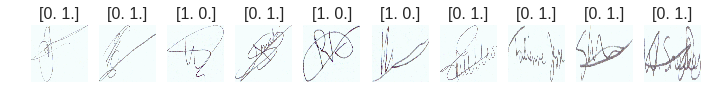

In [12]:
imgs, labels = next(train_batches)
plots(imgs, titles=labels)

In [13]:
vgg16_model = keras.applications.vgg16.VGG16()
model = Sequential()
for layer in vgg16_model.layers:
    model.add(layer)

model.layers.pop()
model.add(Dense(2, activation='softmax'))

for layer in model.layers[:]:
    layer.trainable = True
for layer in model.layers[9:]:
    layer.trainable = False
model.summary()

model.compile(Adam(lr=.0001), loss='categorical_crossentropy', metrics=['accuracy'])

209346560/553467096 [==========>...................] - ETA: 56s

553476096/553467096 [==============================] - 54s 0us/step
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_p

In [14]:
model.fit_generator(train_batches, steps_per_epoch=4, 
                    validation_data=valid_batches, validation_steps=4, epochs=20, verbose=2)

Epoch 1/20
 - 6s - loss: 0.6936 - acc: 0.5000 - val_loss: 0.6925 - val_acc: 0.5500
Epoch 2/20
 - 2s - loss: 0.6933 - acc: 0.5250 - val_loss: 0.6928 - val_acc: 0.6000
Epoch 3/20
 - 2s - loss: 0.6934 - acc: 0.4500 - val_loss: 0.6930 - val_acc: 0.5500
Epoch 4/20
 - 2s - loss: 0.6931 - acc: 0.4750 - val_loss: 0.6942 - val_acc: 0.3750
Epoch 5/20
 - 2s - loss: 0.6932 - acc: 0.4750 - val_loss: 0.6945 - val_acc: 0.3750
Epoch 6/20
 - 2s - loss: 0.6910 - acc: 0.5250 - val_loss: 0.6943 - val_acc: 0.3750
Epoch 7/20
 - 2s - loss: 0.6876 - acc: 0.4250 - val_loss: 0.6946 - val_acc: 0.4000
Epoch 8/20
 - 2s - loss: 0.6871 - acc: 0.6250 - val_loss: 0.6891 - val_acc: 0.6500
Epoch 9/20
 - 2s - loss: 0.6875 - acc: 0.5750 - val_loss: 0.6933 - val_acc: 0.5500
Epoch 10/20
 - 2s - loss: 0.6807 - acc: 0.6750 - val_loss: 0.6869 - val_acc: 0.7250
Epoch 11/20
 - 2s - loss: 0.6833 - acc: 0.6750 - val_loss: 0.6842 - val_acc: 0.7000
Epoch 12/20
 - 2s - loss: 0.6777 - acc: 0.7250 - val_loss: 0.6834 - val_acc: 0.7000
E

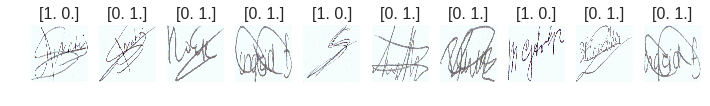

In [15]:
test_imgs, test_labels = next(test_batches)
plots(test_imgs, titles=test_labels)
test_labels = test_labels[:,0]
predictions = model.predict_generator(test_batches, steps=1, verbose=0)

Confusion matrix, without normalization
[[7 0]
 [2 1]]


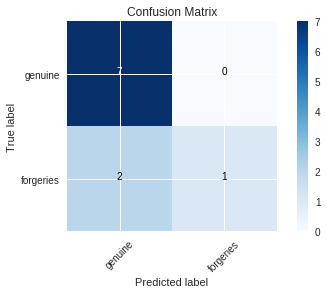

In [16]:

cm = confusion_matrix(test_labels, np.round(predictions[:,0]))
cm_plot_labels = [ 'genuine', 'forgeries' ]
plot_confusion_matrix(cm, cm_plot_labels, title='Confusion Matrix')